## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load data 
# ----------
import numpy as np
import pandas as pd
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
np.random.seed(42)
congress_tweets = congress_tweets.sample(n=5000)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


Actually, I'm not sure if I should be adding these new columns (below) back into the dataset because I'm only taking a small sample of the dataset. I'll re-think this when I go into Part II of the project.

In [3]:
#Create dictionary for states' 2012 and 2016 election results, store it in dataset because we probably will do some change over time stuff related to RQ2
mappedstates = {}  # Create an empty dictionary to hold state mappings

# Iterate over rows for 2012 data
for index, row in congress_tweets.iterrows():
    if row['obama_2012_state_share'] > row['romney_2012_state_share']:
        mappedstates[row['state']] = ['Democrat2012', None]  # Assign Democrat for 2012
    else:
        mappedstates[row['state']] = ['Republican2012', None]  # Assign Republican for 2012

# Iterate over rows for 2016 data and update mappings
for index, row in congress_tweets.iterrows():
    if row['clinton_2016_state_share'] > row['trump_2016_state_share']:
        mappedstates[row['state']][1] = 'Democrat2016'  # Update 2016 to Democrat
    else:
        mappedstates[row['state']][1] = 'Republican2016'  # Update 2016 to Republican

# Create new columns for party affiliation in 2012 and 2016
congress_tweets['party_2012'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[0])
congress_tweets['party_2016'] = congress_tweets['state'].map(lambda state: mappedstates.get(state, [None, None])[1])

# Check the updated DataFrame
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016


In [4]:
#Play around with formatting of temporal variables
congress_tweets['joined_congress_date'] = pd.to_datetime(congress_tweets['joined_congress_date'], format='%d-%b-%y')

congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'], format='%m/%d/%Y')

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016


In [5]:
#Obviously a person's name does not change, even if their screen name does. What we want to do is capture all the screen names associated with a particular individual

# Create a mapping dictionary from 'screen_name' to 'name_wikipedia'
screenname_to_wiki = dict(zip(congress_tweets['screen_name'], congress_tweets['name_wikipedia']))

# Map the dictionary to create the 'mapped_wikipedia' column
congress_tweets['mapped_wikipedia'] = congress_tweets['screen_name'].map(screenname_to_wiki)

# Group by 'mapped_wikipedia' and aggregate 'screen_names' into a list, ensuring uniqueness
screenname_grouped = congress_tweets.groupby('mapped_wikipedia')['screen_name'].apply(lambda x: list(set(x))).reset_index()

# Rename the column in 'screenname_grouped' to 'screen_name_all'
screenname_grouped = screenname_grouped.rename(columns={'screen_name': 'screen_name_all'})

# Merge the aggregated 'screen_name_all' back into the original DataFrame
congress_tweets = congress_tweets.merge(screenname_grouped[['mapped_wikipedia', 'screen_name_all']], 
                                        on='mapped_wikipedia', 
                                        how='left', 
                                        suffixes=('', '_merged'))

# Identify and drop any redundant 'screen_name_all' columns, leaving only the correct one
columns_to_drop = [col for col in congress_tweets.columns if 'screen_name_all' in col and col != 'screen_name_all']
congress_tweets.drop(columns=columns_to_drop, inplace=True)

# Drop the 'mapped_wikipedia' column
congress_tweets.drop(columns='mapped_wikipedia', inplace=True)

# Check results
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,party_2012,party_2016,screen_name_all
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670",Democrat2012,Democrat2016,[RepJayapal]
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,1,Democrat,"673,215","897,572","905,083","634,892",Democrat2012,Democrat2016,[RepJohnLarson]
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Democrat2012,Democrat2016,[SpeakerPelosi]
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843",Republican2012,Republican2016,[JoaquinCastrotx]
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Democrat2012,Democrat2016,[RepJoeMorelle]


In [6]:
# Filter rows where 'screen_name_all' contains more than one screen name
multiple_screen_names = congress_tweets[congress_tweets['screen_name_all'].apply(len) > 1]

# Display rows with multiple screen names
print(multiple_screen_names[['screen_name_all']])


Empty DataFrame
Columns: [screen_name_all]
Index: []


Lol, so there seem to be no updated screen names in this sample, I'm going to keep this code though, since the project PDF indicated that there will be different screen names for the same individual in some cases.

In [7]:
#Trying this on Kamala Harris 
specific_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Kamala Harris'][['screen_name', 'name_wikipedia']]

# Print the selected columns
print(specific_rows)

          screen_name name_wikipedia
80    SenKamalaHarris  Kamala Harris
86    SenKamalaHarris  Kamala Harris
486   SenKamalaHarris  Kamala Harris
498   SenKamalaHarris  Kamala Harris
658   SenKamalaHarris  Kamala Harris
792   SenKamalaHarris  Kamala Harris
817   SenKamalaHarris  Kamala Harris
870   SenKamalaHarris  Kamala Harris
1111  SenKamalaHarris  Kamala Harris
1711  SenKamalaHarris  Kamala Harris
2251  SenKamalaHarris  Kamala Harris
2408  SenKamalaHarris  Kamala Harris
2425  SenKamalaHarris  Kamala Harris
3210  SenKamalaHarris  Kamala Harris
4098  SenKamalaHarris  Kamala Harris
4300  SenKamalaHarris  Kamala Harris
4460  SenKamalaHarris  Kamala Harris
4681  SenKamalaHarris  Kamala Harris
4756  SenKamalaHarris  Kamala Harris


In [8]:
#Bernie Sanders - Democrat
berniesanders_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Bernie Sanders'][['screen_name', 'name_wikipedia']]
print(berniesanders_rows)
print(berniesanders_rows.shape[0])

     screen_name  name_wikipedia
273   SenSanders  Bernie Sanders
775   SenSanders  Bernie Sanders
789   SenSanders  Bernie Sanders
1080  SenSanders  Bernie Sanders
1096  SenSanders  Bernie Sanders
1163  SenSanders  Bernie Sanders
1336  SenSanders  Bernie Sanders
1403  SenSanders  Bernie Sanders
1631  SenSanders  Bernie Sanders
1700  SenSanders  Bernie Sanders
1851  SenSanders  Bernie Sanders
1982  SenSanders  Bernie Sanders
2368  SenSanders  Bernie Sanders
2824  SenSanders  Bernie Sanders
3065  SenSanders  Bernie Sanders
3168  SenSanders  Bernie Sanders
3468  SenSanders  Bernie Sanders
3504  SenSanders  Bernie Sanders
4137  SenSanders  Bernie Sanders
4497  SenSanders  Bernie Sanders
4860  SenSanders  Bernie Sanders
21


In [9]:
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Bernie Sanders', 'party'] = 'Democrat'

# Verify the update
berniesanders_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Bernie Sanders'][['screen_name', 'name_wikipedia', 'party']]
print(berniesanders_rows)

     screen_name  name_wikipedia     party
273   SenSanders  Bernie Sanders  Democrat
775   SenSanders  Bernie Sanders  Democrat
789   SenSanders  Bernie Sanders  Democrat
1080  SenSanders  Bernie Sanders  Democrat
1096  SenSanders  Bernie Sanders  Democrat
1163  SenSanders  Bernie Sanders  Democrat
1336  SenSanders  Bernie Sanders  Democrat
1403  SenSanders  Bernie Sanders  Democrat
1631  SenSanders  Bernie Sanders  Democrat
1700  SenSanders  Bernie Sanders  Democrat
1851  SenSanders  Bernie Sanders  Democrat
1982  SenSanders  Bernie Sanders  Democrat
2368  SenSanders  Bernie Sanders  Democrat
2824  SenSanders  Bernie Sanders  Democrat
3065  SenSanders  Bernie Sanders  Democrat
3168  SenSanders  Bernie Sanders  Democrat
3468  SenSanders  Bernie Sanders  Democrat
3504  SenSanders  Bernie Sanders  Democrat
4137  SenSanders  Bernie Sanders  Democrat
4497  SenSanders  Bernie Sanders  Democrat
4860  SenSanders  Bernie Sanders  Democrat


In [10]:
#Angus King - Democrat
angusking_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Angus King'][['screen_name', 'name_wikipedia']]
print(angusking_rows.shape[0])
print(angusking_rows)

13
       screen_name name_wikipedia
417   SenAngusKing     Angus King
1390  SenAngusKing     Angus King
1869  SenAngusKing     Angus King
2634  SenAngusKing     Angus King
3004  SenAngusKing     Angus King
3399  SenAngusKing     Angus King
3592  SenAngusKing     Angus King
3811  SenAngusKing     Angus King
3895  SenAngusKing     Angus King
3938  SenAngusKing     Angus King
4158  SenAngusKing     Angus King
4186  SenAngusKing     Angus King
4809  SenAngusKing     Angus King


In [11]:
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Angus King', 'party'] = 'Democrat'

# Verify the update
angusking_rows = congress_tweets[congress_tweets['name_wikipedia'] == 'Angus King'][['screen_name', 'name_wikipedia', 'party']]
print(angusking_rows)

       screen_name name_wikipedia     party
417   SenAngusKing     Angus King  Democrat
1390  SenAngusKing     Angus King  Democrat
1869  SenAngusKing     Angus King  Democrat
2634  SenAngusKing     Angus King  Democrat
3004  SenAngusKing     Angus King  Democrat
3399  SenAngusKing     Angus King  Democrat
3592  SenAngusKing     Angus King  Democrat
3811  SenAngusKing     Angus King  Democrat
3895  SenAngusKing     Angus King  Democrat
3938  SenAngusKing     Angus King  Democrat
4158  SenAngusKing     Angus King  Democrat
4186  SenAngusKing     Angus King  Democrat
4809  SenAngusKing     Angus King  Democrat


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [12]:
##this pretty unelegant but I basically kept adding stuff to be removed each time I went back to the tweets and found something
import html
import spacy
import re
from string import punctuation

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def rem_punc_stop(text):
    stop_words = STOP_WORDS  # List of common stopwords in English
    punc = set(punctuation)  # Set of punctuation characters
    
    # Decode HTML escape codes like &amp;
    text = html.unescape(text)  # Decode other HTML escape codes like &lt;, &gt;, etc.
    text = text.replace('&', '')  # Manually remove '&' symbol
    
    # Remove newline characters and unnecessary whitespaces
    text = text.replace('\n', ' ').strip()
    
    # Remove URLs using regex before SpaCy tokenization
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # Removes URLs like http://, https://, www.*
    
    # Remove punctuation (except mentions)
    punc_free = "".join([ch for ch in text if ch not in punc or ch == '@'])  # Keep @ for mentions
    
    # Process the text with SpaCy
    doc = nlp(punc_free)

    # Get all words, excluding URLs using the 'like_url' attribute from SpaCy
    spacy_words = [token.text for token in doc if not token.like_url]  # Excludes URLs
    
    # Remove empty strings or unwanted space tokens
    spacy_words = [word for word in spacy_words if word.strip()]
    
    # Remove the word 'nt' specifically
    spacy_words = [word for word in spacy_words if word.lower() != 'nt']
    
    # Filter out stop words and convert to lowercase
    no_punc = [word for word in spacy_words if word.lower() not in stop_words]
    
    return no_punc


In [13]:
# Test tweet
tweet_text = """It doesn't matter the topic- from standing up for #civilrights &amp; #sexualassault survivors to regulating #forprofitcolleges- @BetsyDeVosED sides with the lenders and the corporations- not students. She is working against the mission of the @usedgov. https://twitter.com/RepKClark/status/1108874640838049792 QT @RepKClark For the 2nd year in a row, the @StateDept erased #reproductivehealth- maternal and comprehensive care- from the annual #humanrights report. I filed a bill to demand they treat women's health for what it is: a #humanright. https://twitter.com/RepKClark/status/1108872716264882176"""

# Apply the function to the tweet_text
cleaned_text = rem_punc_stop(tweet_text)

# Print the cleaned text
print(cleaned_text)

['matter', 'topic', 'standing', 'civilrights', 'sexualassault', 'survivors', 'regulating', 'forprofitcolleges', '@BetsyDeVosED', 'sides', 'lenders', 'corporations', 'students', 'working', 'mission', '@usedgov', 'QT', '@RepKClark', '2nd', 'year', 'row', '@StateDept', 'erased', 'reproductivehealth', 'maternal', 'comprehensive', 'care', 'annual', 'humanrights', 'report', 'filed', 'bill', 'demand', 'treat', 'womens', 'health', 'humanright']


In [14]:
# apply the function to the 'text' i.e. tweet column
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

0       [RT, @RepKClark, 22, million, Americans, filed...
1               [Thanks, came, tonight, forum, GOPTaxLaw]
2       [RT, @RepFilemonVela, Dreamers, TPS, recipient...
3       [RT, @HispanicCaucus, @JoaquinCastrotx, @TheBl...
4       [Thank, @NYGovCuomo, today, face, extreme, wea...
                              ...                        
4995    [RT, @SenatorBraun, officially, ALSAwarenessMo...
4996    [Powerful, words, today, friend, colleague, @S...
4997    [RT, @Ch2KTUU, Alaska, Senator, Dan, Sullivan,...
4998    [Open, schools, QT, @kyoag, Today, 38, Senator...
4999    [Great, news, @ConnectTransit, week, @RodneyDa...
Name: tokens, Length: 5000, dtype: object

In [15]:
#!git status

In [16]:
#!git add "Taylor Updates Project 5 Student.ipynb"

In [17]:
#!git status

In [18]:
#!git commit -m "New commits"

In [19]:
#!git push

### Retweets and Quote Tweets

In [20]:
# Add a new column to categorize tweet types (Retweet, Quote Tweet, Mentioned, or Neither)
congress_tweets['tweet_type'] = congress_tweets['text'].apply(
    lambda x: 'Retweet' if 'RT ' in str(x) else ('Quote Tweet' if 'QT ' in str(x) else ('Simple Mentioned' if '@' in str(x) else 'Neither'))
)

# Count the number of each type
retweets_count = congress_tweets[congress_tweets['tweet_type'] == 'Retweet'].shape[0]
quote_tweets_count = congress_tweets[congress_tweets['tweet_type'] == 'Quote Tweet'].shape[0]
mentioned_count = congress_tweets[congress_tweets['tweet_type'] == 'Simple Mentioned'].shape[0]
neither_count = congress_tweets[congress_tweets['tweet_type'] == 'Neither'].shape[0]

# Print the counts
print(f"Number of tweets containing Retweets: {retweets_count}")
print(f"Number of tweets containing Quote Tweets: {quote_tweets_count}")
print(f"Number of tweets containing Simple Mentions: {mentioned_count}")
print(f"Number of tweets containing Neither: {neither_count}")


Number of tweets containing Retweets: 1208
Number of tweets containing Quote Tweets: 556
Number of tweets containing Simple Mentions: 1156
Number of tweets containing Neither: 2080


In [21]:
import re

# Create a new column to categorize tweet types (Retweet, Quote Tweet, Simple Mention, or Neither)
congress_tweets['tweet_type'] = congress_tweets['text'].apply(
    lambda x: 'Retweet' if 'RT ' in str(x) else ('Quote Tweet' if 'QT ' in str(x) else ('Simple Mentioned' if '@' in str(x) else 'Neither'))
)

# Function to extract mentions from the tweet text
def extract_mentions(text):
    return re.findall(r'@([a-zA-Z0-9_]+)', text)

# Add a new column to store mentions for each tweet
congress_tweets['mentioned_in_tweet'] = congress_tweets['text'].apply(lambda x: extract_mentions(x) if 'RT ' in x or 'QT ' in x or '@' in x else [])

# Check the results by printing the first few rows of the DataFrame
print(congress_tweets[['text', 'mentioned_in_tweet']].head())


                                                text  \
0  RT @RepKClark 22 million Americans filed for u...   
1  Thanks to all who came out to tonight’s forum ...   
2  RT @RepFilemonVela #Dreamers &amp; TPS recipie...   
3  RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...   
4  Thank you to @NYGovCuomo for being here today ...   

                                  mentioned_in_tweet  
0                              [RepKClark, politico]  
1                                                 []  
2                                   [RepFilemonVela]  
3  [HispanicCaucus, JoaquinCastrotx, TheBlackCauc...  
4                                       [NYGovCuomo]  


Now there are some analytic choices here. For quote tweets, we will probably need to conceptualize this as a conversation, where the sentiment/message of the original tweet could ostensibly be the opposite of the re-poster. (I.e. "I can't believe that this person said this!" However, should 'simple' re-tweets be considered representative of the person doing the re-tweeting? (I.e. emphasizing/affirming the encapsulated idea? ) Or should they be attributed to the original speaker/author(s) instead? What should we do if multiple people are being referenced? 

Coming back to the RT/QT issue in part 2 of this project, since the 'RT' and 'QT' are messing up my analyses (word embeddings, etc.), my provisional solution is going to be to create a new column that demonstrates if a tweet is a RT or QT, and then take the actual letters 'RT' and 'QT' out. That way, I can still see if the meaning changes if it's a RT or QT, but it doesn't mess up my analysis. I'm also going to store all the 'mentioned' users in a new column called 'mentioned_in_tweet', in case we need them, but I'll take that out of the text. I'm also going to take out URLs.

In [22]:
import html
import spacy
import re
from string import punctuation

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def clean_and_tokenize_combined(text):
    # Remove URLs and 'RT'/'QT' mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\b(RT|QT)\s?@\w+', '', text)  # Remove 'RT' or 'QT' mentions

    # Remove 'RT' and 'QT' directly from the text (without tokenization)
    text = re.sub(r'\b(RT|QT)\b', '', text)  # Remove 'RT' and 'QT' from the text
    
    # Remove all mentions (i.e., anything starting with '@')
    text = re.sub(r'@\w+', '', text)
    
    # Replace HTML encoded characters
    text = html.unescape(text)  # Decode HTML escape codes like &lt;, &gt;, etc.
    text = text.replace('&', '')  # Manually remove '&' symbol
    
    # Fix the decimal points in numbers (prevent "5. 2" becoming "5.2")
    text = re.sub(r'(\d+)\.\s+(\d+)', r'\1.\2', text)
    
    # Fix percentage and currency values (prevent "10 0%" becoming "100%")
    text = re.sub(r'(\d+)\s+(\d+)([%k])', r'\1\2\3', text)
    text = re.sub(r'(\$)(\d+)\s+(\d+)([k]?)', r'\1\2\3\4', text)
    
    # Fix spacing issues with parentheses
    text = re.sub(r'(\w)\(', r'\1 (', text)
    text = re.sub(r'\)(\w)', r') \1', text)
    
    # Fix spacing around hashtags and mentions
    text = re.sub(r'(?<=\w)(#\w+)', r' \1', text)
    text = re.sub(r'(?<!\s)(@\w+)', r' \1', text)
    
    # Fix spacing around punctuation
    text = re.sub(r'\s+([.,;!?:])', r'\1', text)  # No space before punctuation
    text = re.sub(r'([.,;!?:])\s+', r'\1 ', text)  # Ensure single space after punctuation
    
    # Fix spacing for hashtag with numbers (e.g., #HR 6)
    text = re.sub(r'(#[A-Za-z]+)\s+(\d+)', r'\1\2', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)

    # Do not remove non-alphabetic characters at this point (allow SpaCy to handle tokenization)

    # Process the text with SpaCy (keeping @mentions)
    doc = nlp(text)

    # Get all words, excluding URLs using the 'like_url' attribute from SpaCy
    spacy_words = [token.text for token in doc if not token.like_url]  # Excludes URLs
    
    # Remove empty strings or unwanted space tokens
    spacy_words = [word for word in spacy_words if word.strip()]
    
    # Remove the word 'nt' specifically
    spacy_words = [word for word in spacy_words if word.lower() != 'nt']
    
    # Remove unwanted single-letter tokens
    unwanted_single_letter_tokens = {'s', 'u', 't', 'r', 'a', 'b', 'i', 'c', 'd'}  # Add more if needed
    spacy_words = [word for word in spacy_words if len(word) > 1 and word.lower() not in unwanted_single_letter_tokens]

    # Filter out stop words and convert to lowercase
    stop_words = nlp.Defaults.stop_words  # Get default SpaCy stopwords
    no_punc = [word for word in spacy_words if word.lower() not in stop_words]

    # Explicitly remove 'RT' and 'QT' from the token list
    no_punc = [word for word in no_punc if word.lower() not in ['rt', 'qt']]

    return no_punc

# Apply the combined function to the 'text' column
congress_tweets['tokens'] = congress_tweets['text'].apply(clean_and_tokenize_combined)

# Check the first few rows of tokens to ensure the function works
print(congress_tweets['tokens'].head())

0    [22, million, Americans, filed, unemployment, ...
1            [Thanks, came, tonight, forum, GOPTaxLaw]
2    [Dreamers, TPS, recipients, essential, members...
3    [CEOS, represent, largest, Pharmacy, Benefit, ...
4    [Thank, today, face, extreme, weather, system,...
Name: tokens, dtype: object


In [23]:
# Check if the tokens column is now a list of lists (it was string)
print(type(congress_tweets['tokens'][0]))  # This should print <class 'list'>
print(len(congress_tweets['tokens']))  # This should be the number of tweets/sentences
print(congress_tweets['tokens'].head())  # Check the first few tokenized tweets

<class 'list'>
5000
0    [22, million, Americans, filed, unemployment, ...
1            [Thanks, came, tonight, forum, GOPTaxLaw]
2    [Dreamers, TPS, recipients, essential, members...
3    [CEOS, represent, largest, Pharmacy, Benefit, ...
4    [Thank, today, face, extreme, weather, system,...
Name: tokens, dtype: object


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

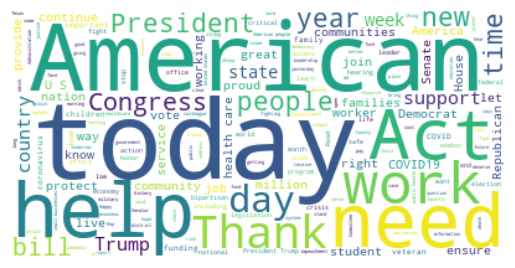

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the list of tokens in each row into one large string
text = ' '.join(congress_tweets['tokens'].apply(lambda x: ' '.join(x)))

# Create WordCloud visualization using the "text" object 
wordcloud = WordCloud(
    background_color="white",  # set background color to white
    random_state=41            # set random state to ensure the same word cloud each time
).generate(text)  # generate word cloud from the text

# Plot
plt.imshow(wordcloud, interpolation='bilinear')  # specify wordcloud
plt.axis('off')  # turn off axes
plt.show()  # show the plot



## EDA 2

In [25]:
#import scattertext as st
#import pandas as pd
#import spacy
# create measure of subjectivity
# Load SpaCy model
#nlp = spacy.load("en_core_web_sm")

#congress_tweets['tokens'] = congress_tweets['text'].apply(lambda x: [token.text for token in nlp(x) if not token.is_stop and not token.is_punct])
#congress_tweets['tokens_str'] = congress_tweets['tokens'].apply(lambda x: ' '.join(x))

# Create the Corpus for Scattertext
#corpus = st.CorpusFromPandas(
  #  congress_tweets,              
  #  category_col='party',         
  #  text_col='tokens_str',      
  #  nlp=nlp                      
#).build()

# create html document
#html = st.produce_scattertext_explorer(
    #corpus,
    #category='Republican',             
    #category_name='Republican',        
   # not_category_name='Democrat',      
   # width_in_pixels=1000,              
   # minimum_term_frequency=5,         
   # metadata=congress_tweets['position']  
#)

# write html document to memory and open in browser
#with open("Congress_Tweets_Sentiment.html", 'wb') as f:
 #   f.write(html.encode('utf-8'))

#print("Congress_Tweets_Sentiment.html")


In [26]:
#open("Congress_Tweets_Sentiment.html", 'wb').write(html.encode('utf-8'))

## EDA 3

In [27]:
# create new feature columns with counts of # of characters and # of words
# ----------

# Count number of characters in tokens (joined back into a string)
congress_tweets['tweet_len'] = congress_tweets['tokens'].apply(lambda x: len(' '.join(x)))

# Count number of words in tokens
congress_tweets['word_count'] = congress_tweets['tokens'].apply(len)

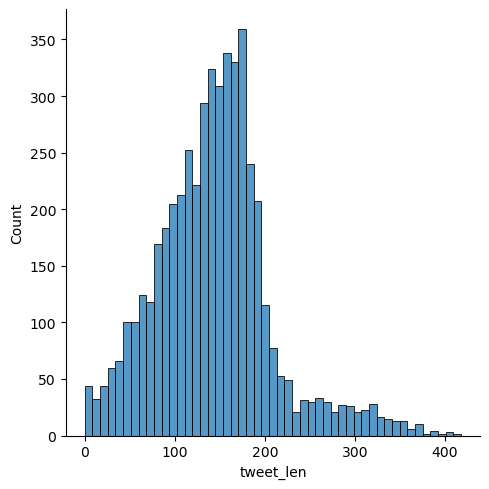

In [28]:
# create histogram of complaint length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="tweet_len") # x-axis feature
plt.show()

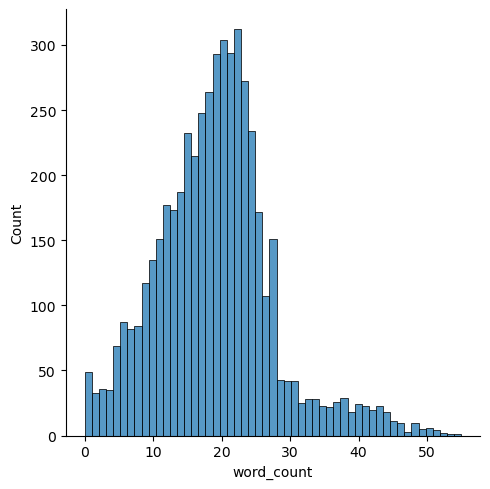

In [29]:
# create histogram of word count
sns.displot(congress_tweets,           # specify data 
            x="word_count") # x-axis feature
plt.show()

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [30]:
# create a feature column of sentiment polarity and subjectivity
# ---------- 
# Join the tokens into a single string before applying TextBlob
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda tokens: ' '.join(tokens))

# create the "polarity" column 
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# create the "subjectivity" column again 
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# view
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party_2012,party_2016,screen_name_all,tokens,tweet_type,mentioned_in_tweet,tweet_len,word_count,polarity,subjectivity
0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,2017-01-03,1965-09-21,F,WA,...,Democrat2012,Democrat2016,[RepJayapal],22 million Americans filed unemployment weeks ...,Retweet,"[RepKClark, politico]",283,37,0.350000,0.800000
1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,1999-01-03,1948-07-22,M,CT,...,Democrat2012,Democrat2016,[RepJohnLarson],Thanks came tonight forum GOPTaxLaw,Neither,[],35,5,0.200000,0.200000
2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,1987-06-02,1940-03-26,F,CA,...,Democrat2012,Democrat2016,[SpeakerPelosi],Dreamers TPS recipients essential members comm...,Retweet,[RepFilemonVela],135,17,0.000000,0.300000
3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,2013-01-03,1974-09-16,M,TX,...,Republican2012,Republican2016,[JoaquinCastrotx],CEOS represent largest Pharmacy Benefit Manage...,Retweet,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",179,23,0.000000,1.000000
4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,2018-11-13,1957-04-29,M,NY,...,Democrat2012,Democrat2016,[RepJoeMorelle],Thank today face extreme weather system close ...,Simple Mentioned,[NYGovCuomo],156,21,0.208333,0.583333


Let's see the list of democrats and republicans in our dataset to see who to choose for this sentiment analaysis. (We're just going to map liberal and conservative along party lines for the purposes of this project, that's a big assumption, though.)

## Finding liberal and conservative members - Nancy Pelosi and Ted Cruz

In [31]:
# List of democrats
democrats = congress_tweets[congress_tweets['party'] == 'Democrat'][['screen_name', 'state']]

# Print the selected columns
print(democrats)

# List of republicans
republicans = congress_tweets[congress_tweets['party'] == 'Republican'][['screen_name', 'state']]

# Print the selected columns
print(republicans)


          screen_name state
0          RepJayapal    WA
1       RepJohnLarson    CT
2       SpeakerPelosi    CA
3     JoaquinCastrotx    TX
4       RepJoeMorelle    NY
...               ...   ...
4989    RepAngieCraig    MN
4991        SenMarkey    MA
4993    RepJohnLarson    CT
4994      RepFletcher    TX
4995       ChrisCoons    DE

[3295 rows x 2 columns]
          screen_name state
6      RepAndyBiggsAZ    AZ
9     CongMikeSimpson    ID
10        RepJimBanks    IN
12     RepBillJohnson    OH
13         JohnCornyn    TX
...               ...   ...
4992       SenTedCruz    TX
4996  AustinScottGA08    GA
4997   SenDanSullivan    AK
4998         RandPaul    KY
4999        RepLaHood    IL

[1705 rows x 2 columns]


Let's choose Nancy Pelosi as our liberal (lol) and Ted Cruz as our conservative. 

In [32]:
pelositweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Nancy Pelosi']
pelositweets = pd.DataFrame(pelositweets) 
cruztweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Ted Cruz']
cruztweets = pd.DataFrame(cruztweets) 

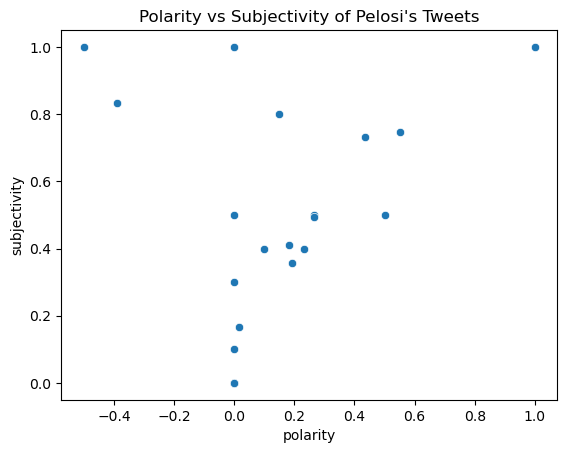

In [33]:
sns.scatterplot(data=pelositweets, x="polarity", y="subjectivity")
plt.title("Polarity vs Subjectivity of Pelosi's Tweets")
plt.show()

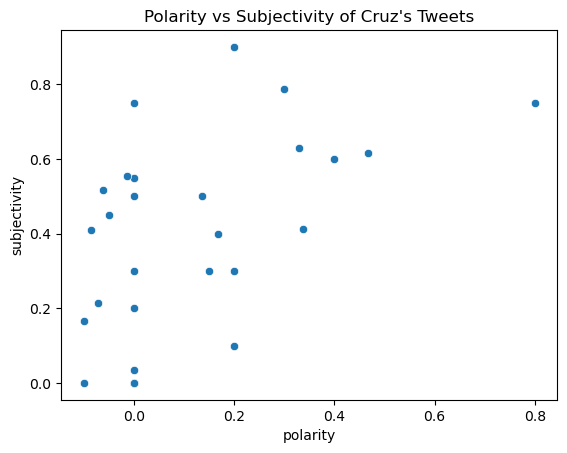

In [34]:
sns.scatterplot(data=cruztweets, x="polarity", y="subjectivity")
plt.title("Polarity vs Subjectivity of Cruz's Tweets")
plt.show()

## Democrats vs. Republicans

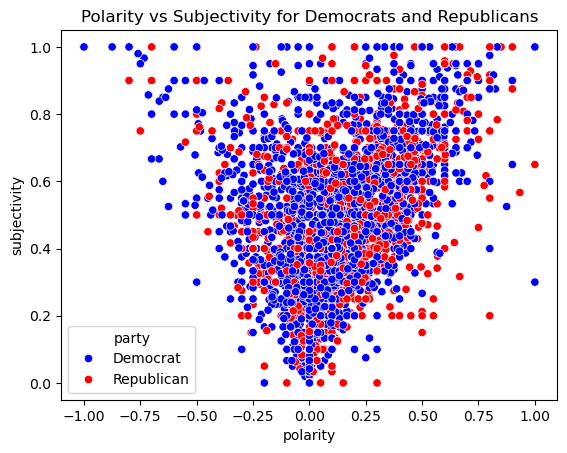

In [35]:
# Create the scatter plot
# Define a custom color palette: Blue for Democrats, Red for Republicans
party_palette = {'Democrat': 'blue', 'Republican': 'red', 'Independent': 'yellow'}
sns.scatterplot(data=congress_tweets, x="polarity", y="subjectivity", hue="party", palette=party_palette)

# Add plot title and show the plot
plt.title("Polarity vs Subjectivity for Democrats and Republicans")
plt.show()

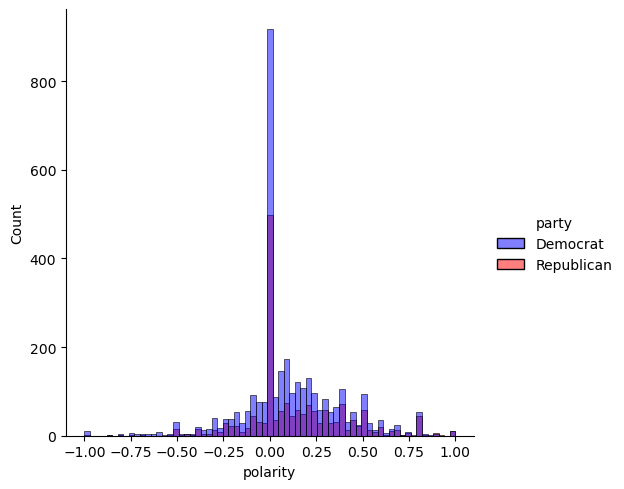

In [36]:
# histogram of polarity by party
sns.displot(congress_tweets,            # specify data
            x="polarity",    # specify x-axix feature 
            hue = "party", # color by party
            palette=party_palette) # color by party
plt.show()

## Senators vs. Representatives

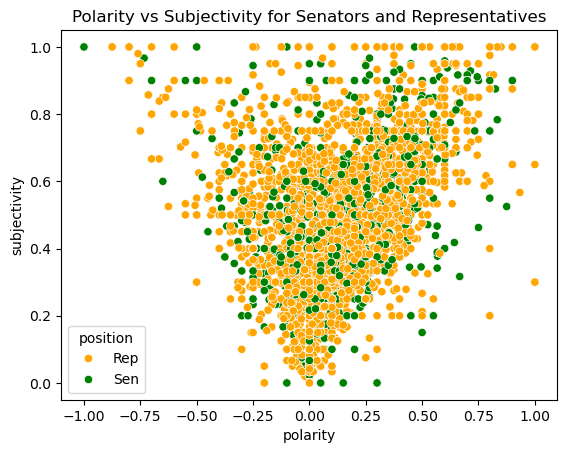

In [37]:
# Create the scatter plot
# Define a custom color palette: Blue for Democrats, Red for Republicans
position_palette = {'Rep': 'orange', 'Sen': 'green'}
sns.scatterplot(data=congress_tweets, x="polarity", y="subjectivity", hue="position", palette=position_palette)

# Add plot title and show the plot
plt.title("Polarity vs Subjectivity for Senators and Representatives")
plt.show()

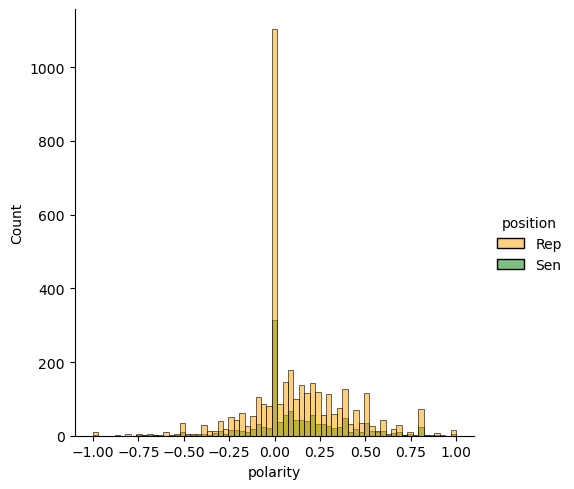

In [38]:
# histogram of polarity by position
sns.displot(congress_tweets,            # specify data
            x="polarity",    # specify x-axix feature 
            hue = "position", # color by position
            palette=position_palette) # color by position
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features - sentiment scores

In [39]:
#Engineered features
engineeredfeatures_df = congress_tweets
engineered_features = ['tweet_len', 'word_count', 'polarity', 'subjectivity']
target_columns = ['party', 'position'] 

# Create a new DataFrame with only the relevant features and target columns
engineeredfeatures_df = engineeredfeatures_df[engineered_features + target_columns]

# Check the new DataFrame
print(engineeredfeatures_df.head())

   tweet_len  word_count  polarity  subjectivity     party position
0        283          37  0.350000      0.800000  Democrat      Rep
1         35           5  0.200000      0.200000  Democrat      Rep
2        135          17  0.000000      0.300000  Democrat      Rep
3        179          23  0.000000      1.000000  Democrat      Rep
4        156          21  0.208333      0.583333  Democrat      Rep


### Tf-IDF

In [40]:

# create tf-idf matrix
# ----------
# set X dataset
X = congress_tweets['text']        

# initialize tf-idf using our preprocessing function
tf = TfidfVectorizer(tokenizer = clean_and_tokenize_combined, # use our function for tokenizing created above
                     token_pattern = None, # set to "None" since we have specify our own pattern
                    max_features=500)      # limit to top 500 features

# fit and transform data
tfidf_matrix =  tf.fit_transform(X)

# create dense matrix just to view
dense_matrix = tfidf_matrix.todense()
dense_matrix 

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# create a useful visualization of tf-idf matrix
# ----------

# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                         columns=tf.get_feature_names_out()) # specify column names as feature names from TF vectorizer

# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
million,0.482975,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
weeks,0.401792,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
unemployment,0.369499,0.0,0.0,0.000000,0.0,0.0,0.300889,0.0,0.337764,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
workers,0.295500,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.398192,0.0,0.0,0.0,0.0,0.0,0.0
americans,0.260288,0.0,0.0,0.301909,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
100,0.202831,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
cover,0.198186,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
breaking,0.186548,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
healthcare,0.181950,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
find,0.171809,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### LDA

In [61]:
#
# Fitting a Latent Dirichlet Allocation model 
# ------------------------------
from sklearn.decomposition import LatentDirichletAllocation

# initialize LDA model 
# ---------- 
lda = LatentDirichletAllocation(n_components=5,   # adjust the # of components
                                max_iter=20,      # adjust the # of iterations to fit model
                                random_state=0)   # set seed for reproducibility

# fit LDA to data
# ---------- 
lda = lda.fit(tfidf_matrix)  # use the sparse matrix created above 
lda

LatentDirichletAllocation(max_iter=20, n_components=5, random_state=0)

In [43]:
# define a function to get and view top words for each topic
# ---------- 
def print_top_words(model, feature_names, n_top_words):    # define function and set parameters
    for topic_idx, topic in enumerate(model.components_):  # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))            # print topic index
        print(" ".join([feature_names[i]                   # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [44]:
# get feature names from tf-idf matrices 
# ---------- 
tf_feature_names = tf.get_feature_names_out()

# apply function to print top words
print_top_words(lda,                # model 
                tf_feature_names,   # feature names 
                20)                 # number of top words


Topic #0:
house president senate trump democrats vote impeachment passed congress bill republicans people election voting act american time read bipartisan de

Topic #1:
today women happy day honor country world years american nation life lives family people lost rights time service america right

Topic #2:
students national act trump children administration high school million climate letter great year need today bill funding energy jobs help

Topic #3:
community tune office discuss today thank police live hearing meeting census joining join law great watch pm tonight coming team

Topic #4:
health care help covid19 need coronavirus workers businesses small families covid-19 relief provide work pandemic state assistance information access communities



In [45]:
# calculate topic weights from distribution
# ----------
topic_dist = lda.transform(tfidf_matrix) # calculate distribution of topics for each document in the corpus 
topic_dist  # note that this output is an array

array([[0.04336482, 0.04280852, 0.04372577, 0.04261315, 0.82748774],
       [0.35677836, 0.08523822, 0.08333837, 0.38872272, 0.08592233],
       [0.05558479, 0.05607199, 0.05421051, 0.054546  , 0.7795867 ],
       ...,
       [0.7613182 , 0.06091418, 0.05899581, 0.05988578, 0.05888603],
       [0.05229622, 0.21179283, 0.63254272, 0.05137728, 0.05199096],
       [0.05080619, 0.05069801, 0.79569012, 0.05093497, 0.05187071]])

In [46]:
# convert topic distribution array to pandas dataframe
# ----------
topic_dist_df = pd.DataFrame(topic_dist)

# join back to pandas dataframe and reset index
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())

# view
df_w_topics.head() # notice that the topic distribution is the first 5 columns

,0,1,2,3,4,index,tweet_id,screen_name,datetime,text,...,party_2012,party_2016,screen_name_all,tokens,tweet_type,mentioned_in_tweet,tweet_len,word_count,polarity,subjectivity
0,0.043365,0.042809,0.043726,0.042613,0.827488,0,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,...,Democrat2012,Democrat2016,[RepJayapal],22 million Americans filed unemployment weeks ...,Retweet,"[RepKClark, politico]",283,37,0.350000,0.800000
1,0.356778,0.085238,0.083338,0.388723,0.085922,1,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,...,Democrat2012,Democrat2016,[RepJohnLarson],Thanks came tonight forum GOPTaxLaw,Neither,[],35,5,0.200000,0.200000
2,0.055585,0.056072,0.054211,0.054546,0.779587,2,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,...,Democrat2012,Democrat2016,[SpeakerPelosi],Dreamers TPS recipients essential members comm...,Retweet,[RepFilemonVela],135,17,0.000000,0.300000
3,0.056013,0.055969,0.056708,0.056052,0.775258,3,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,...,Republican2012,Republican2016,[JoaquinCastrotx],CEOS represent largest Pharmacy Benefit Manage...,Retweet,"[HispanicCaucus, JoaquinCastrotx, TheBlackCauc...",179,23,0.000000,1.000000
4,0.044657,0.044976,0.045020,0.045434,0.819913,4,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,...,Democrat2012,Democrat2016,[RepJoeMorelle],Thank today face extreme weather system close ...,Simple Mentioned,[NYGovCuomo],156,21,0.208333,0.583333


In [47]:
# group by party products and calculate mean
# ----------

# group the topics
grouped = df_w_topics.groupby('party')

# loop over the dataframe and calculate mean
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Democrat      0.196841
Republican    0.192728
Name: 0, dtype: float64
party
Republican    0.201555
Democrat      0.189193
Name: 1, dtype: float64
party
Republican    0.216423
Democrat      0.205396
Name: 2, dtype: float64
party
Democrat      0.159160
Republican    0.157646
Name: 3, dtype: float64
party
Democrat      0.249410
Republican    0.231648
Name: 4, dtype: float64


In [48]:
# group by position products and calculate mean
# ----------

# group the topds
grouped = df_w_topics.groupby('position')

# loop over the dataframe and calculate mean
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

position
Rep    0.197565
Sen    0.188793
Name: 0, dtype: float64
position
Rep    0.194574
Sen    0.189765
Name: 1, dtype: float64
position
Sen    0.225027
Rep    0.204078
Name: 2, dtype: float64
position
Rep    0.164466
Sen    0.140445
Name: 3, dtype: float64
position
Sen    0.255969
Rep    0.239317
Name: 4, dtype: float64


### Word Embedding

In [49]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [50]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [51]:
# Apply the split function to convert each string into a list of tokens
congress_tweets['tokens'] = congress_tweets['tokens'].apply(lambda x: x.split())

In [52]:
# apply CBOW Word2vec model to our cfpb data 
# ----------
model = gensim.models.Word2Vec(congress_tweets['tokens'],    # specify data 
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=1,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000, # sample size 
                               workers = 1)       # set cores to 1 to ensure this embeddings are fully reproducible

In [53]:
# return embeddings for specific word
# ----------
print(model.wv.__getitem__(['American'])) # specify a key word here: "democrat"

[[-3.10749233e-01  5.31449556e-01  2.75777221e-01 -3.30327265e-02
   2.88011469e-02 -1.16891730e+00  5.30810244e-02  1.55921733e+00
  -4.32315916e-01 -4.80131328e-01 -2.09607214e-01 -1.19457221e+00
   9.53892842e-02  4.71094191e-01  3.51502508e-01 -5.44265270e-01
  -8.55134279e-02 -9.54163253e-01  1.75640360e-01 -1.46038890e+00
   4.04043168e-01  2.32094988e-01  4.38309312e-01 -5.08282244e-01
  -6.70847073e-02  2.60695428e-01 -6.14584267e-01 -3.81295800e-01
  -5.09389043e-01  1.42624676e-02  6.02274895e-01  1.72828227e-01
   6.92418516e-02 -4.82546300e-01 -5.42699620e-02  7.98600793e-01
  -1.04415141e-01 -4.29232508e-01 -3.51203382e-01 -1.26249290e+00
   2.95479689e-02 -7.07367957e-01 -1.76000327e-01 -3.26864347e-02
   4.85167682e-01 -3.20771486e-01 -5.34708560e-01 -5.82312457e-02
   3.33398283e-01  5.47699690e-01  2.69824296e-01 -4.63932931e-01
  -4.31178957e-01 -1.52035266e-01 -3.68484139e-01  4.46714669e-01
   3.90111804e-01 -2.60090847e-02 -4.67449844e-01  1.21027948e-02
   1.86767

In [54]:
words = list(model.wv.index_to_key)
print(words[0:100])

['Trump', 'people', 'help', 'today', 'House', 'need', 'President', 'health', 'Act', 'American', 'work', 'Congress', 'Americans', 'time', 'Today', 'bill', 'support', 'country', 'families', 'Senate', 'care', 'COVID19', 'communities', 'community', 'continue', 'years', 'workers', 'day', 'new', 'America', 'protect', 'week', 'year', 'Thank', 'public', 'federal', 'working', 'like', 'U.S.', 'right', 'legislation', 'nation', 'businesses', 'law', 'Democrats', 'ensure', 'family', 'crisis', 'important', 'COVID-19', 'state', 'coronavirus', 'funding', 'pandemic', 'vote', 'lives', 'proud', 'bipartisan', 'relief', 'safe', 'women', 'fight', 'passed', 'great', 'provide', '...', 'know', 'children', 'access', 'office', 'million', 'pass', 'students', 'stop', 'life', 'honor', 'small', 'economy', 'government', 'local', 'service', 'way', 'world', 'forward', 'national', 'critical', 'Read', 'jobs', 'Republicans', 'security', 'better', 'join', 'resources', 'home', 'including', 'joined', 'impeachment', 'hearing',

In [55]:
# Extract words and their corresponding vectors
words = list(model.wv.index_to_key)  # All words in the vocabulary
vectors = [model.wv[word] for word in words]  # List of word vectors

# Create a DataFrame where each row corresponds to a word and its vector
word_vectors_df = pd.DataFrame(vectors, index=words)

# Print the DataFrame to see the word vectors
print(word_vectors_df.head())

              0         1         2         3         4         5         6   \
Trump  -0.356200  0.643170  0.353380 -0.037722  0.017029 -1.401032  0.093775   
people -0.342911  0.599265  0.326651 -0.041548  0.043399 -1.283337  0.069726   
help   -0.316952  0.579511  0.298402 -0.050088  0.046995 -1.209779  0.060275   
today  -0.359272  0.643887  0.340250 -0.060296  0.042131 -1.349764  0.070908   
House  -0.343351  0.592755  0.306692 -0.054837  0.036971 -1.253470  0.073225   

              7         8         9   ...        90        91        92  \
Trump   1.852727 -0.512822 -0.571738  ...  0.633738  0.309471  0.126046   
people  1.699638 -0.472110 -0.529465  ...  0.582610  0.281108  0.101792   
help    1.626511 -0.451542 -0.487469  ...  0.545917  0.277251  0.109659   
today   1.796398 -0.474384 -0.559182  ...  0.595110  0.297113  0.112538   
House   1.670792 -0.456905 -0.504459  ...  0.574540  0.274158  0.113039   

              93        94        95        96        97        98  

In [56]:
# similarty between democrat and republican
# ----------
model.wv.similarity('Democrats', 'Republicans')

0.99929357

In [57]:
# similarity between democrat/republican and sen/rep
# ----------
model.wv.n_similarity(['Democrats','Republicans'],['Senate','House'])

0.99976945

In [58]:
# which doesn't belong? 1
# ----------
model.wv.doesnt_match(['Senate', 'House', 'Congress'])

'Senate'

In [97]:
len(congress_tweets['tokens'][0])

37

In [96]:
# get model's vocabulary
# ----------
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

37

In [98]:
# find the first vector of each token and find their mean
# ----------
# create empty list
first_vec = []

# loop over each document
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
    
# calculate their mean
np.mean(first_vec)

-0.10895731

In [101]:
# create function to iterate over every token and document in our corpus
# ----------
def document_vector(word2vec_model, doc):
    # Filter out words that are not in the Word2Vec model's vocabulary
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    
    # If no words are in the vocabulary, return a zero vector
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    # Get the word vectors for each word in the document and compute the mean
    word_vectors = word2vec_model.wv[doc]
    
    # Return the average of the word vectors
    return np.mean(word_vectors, axis=0)

In [102]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for puppy in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[-0.10895731,  0.19673721,  0.10771314, ..., -0.26792079,
         0.13143755, -0.00271878],
       [-0.03853782,  0.06636161,  0.03908775, ..., -0.09819876,
         0.05057958,  0.00377092],
       [-0.09401885,  0.17095242,  0.09380069, ..., -0.2320966 ,
         0.11590066, -0.00243133],
       ...,
       [-0.07576378,  0.1369309 ,  0.07648171, ..., -0.18941596,
         0.08853396,  0.00443432],
       [-0.06752532,  0.1229366 ,  0.06571054, ..., -0.1645304 ,
         0.08306459,  0.00035634],
       [-0.10899629,  0.19480763,  0.10660929, ..., -0.26554918,
         0.12871587, -0.00091563]])

In [103]:
# find the shape 
doc_average_embeddings.shape

(5000, 100)

In [104]:
# Convert the embeddings to a DataFrame
embedding_df = pd.DataFrame(doc_average_embeddings)

# Check the shape of the DataFrame
print(embedding_df.shape)  # Should be (5000, 100)

(5000, 100)


In [105]:
# Add party and position labels as columns to the DataFrame
embedding_df['party'] = congress_tweets['party'].values  # Add the party column
embedding_df['position'] = congress_tweets['position'].values  # Add the position column

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### Model 1 - Predicting Party with Engineered Features

In [59]:
engineeredfeatures_df.head()

,tweet_len,word_count,polarity,subjectivity,party,position
0,283,37,0.350000,0.800000,Democrat,Rep
1,35,5,0.200000,0.200000,Democrat,Rep
2,135,17,0.000000,0.300000,Democrat,Rep
3,179,23,0.000000,1.000000,Democrat,Rep
4,156,21,0.208333,0.583333,Democrat,Rep


In [60]:
from sklearn.model_selection import train_test_split

# For the Democrat/Republican model (using engineered features)
X_train, X_temp, y_train_party, y_temp_party = train_test_split(
    engineeredfeatures_df.drop(['party', 'position'], axis=1),  # Features
    engineeredfeatures_df['party'],  # Target (Democrat/Republican)
    test_size=0.4, random_state=42
)

X_val, X_test, y_val_party, y_test_party = train_test_split(X_temp, y_temp_party, test_size=0.5, random_state=42)

In [62]:
# Initialize the RandomForest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_party = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model for Democrat/Republican prediction using engineered features
rf_party.fit(X_train, y_train_party)

# Predict on the validation set
y_val_pred_party = rf_party.predict(X_val)

# Evaluate the model
print("Democrat/Republican Model (Engineered Features) - Accuracy:", accuracy_score(y_val_party, y_val_pred_party))
print(classification_report(y_val_party, y_val_pred_party))

Democrat/Republican Model (Engineered Features) - Accuracy: 0.608
              precision    recall  f1-score   support

    Democrat       0.67      0.80      0.73       661
  Republican       0.38      0.24      0.29       339

    accuracy                           0.61      1000
   macro avg       0.52      0.52      0.51      1000
weighted avg       0.57      0.61      0.58      1000

Confusion Matrix:
 [[527 134]
 [258  81]]


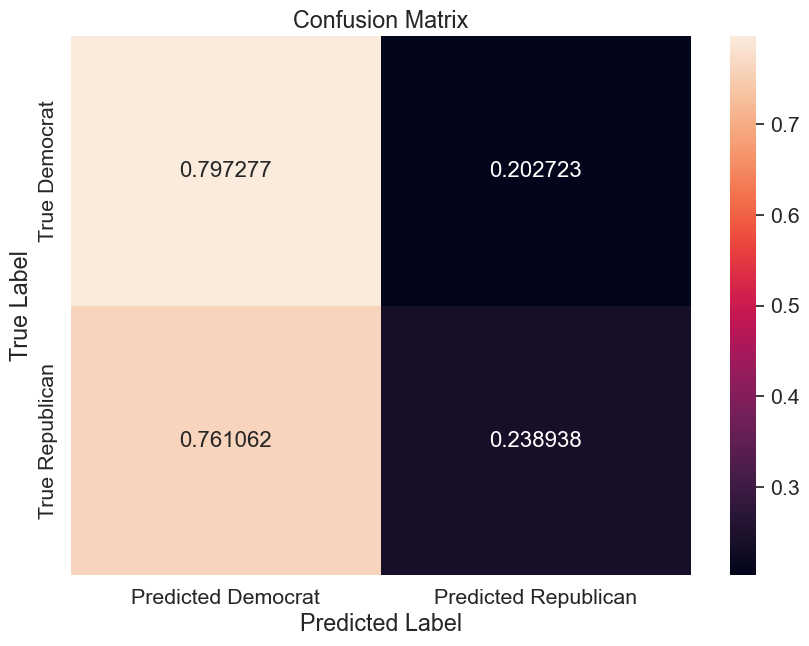

In [66]:
# Create a DataFrame for better visualization
party_engineeredfeaturesdfcf_matrix = confusion_matrix(y_val_party, y_val_pred_party, normalize="true")
party_engineeredfeaturesdf_cm = pd.DataFrame(party_engineeredfeaturesdfcf_matrix, 
                     index=["True Democrat", "True Republican"], 
                     columns=["Predicted Democrat", "Predicted Republican"])

# plot specifications
# ----------
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(party_engineeredfeaturesdf_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Model 2- Predicting Position (Senate/House of Representatives) with Engineered Features

In [67]:
# For the Sen/Rep model (using engineered features)
X_train, X_temp, y_train_position, y_temp_position = train_test_split(
    engineeredfeatures_df.drop(['party', 'position'], axis=1),  # Features
    engineeredfeatures_df['position'],  # Target (Sen/Rep)
    test_size=0.4, random_state=42
)

X_val, X_test, y_val_position, y_test_position = train_test_split(X_temp, y_temp_position, test_size=0.5, random_state=42)

In [68]:
# Initialize the RandomForest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_position = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model for Sen/Rep prediction using engineered features
rf_position.fit(X_train, y_train_position)

# Predict on the validation set
y_val_pred_position = rf_position.predict(X_val)

# Evaluate the model
print("Sen/Rep Model (Engineered Features) - Accuracy:", accuracy_score(y_val_position, y_val_pred_position))
print(classification_report(y_val_position, y_val_pred_position))

Sen/Rep Model (Engineered Features) - Accuracy: 0.717
              precision    recall  f1-score   support

         Rep       0.77      0.90      0.83       775
         Sen       0.18      0.07      0.10       225

    accuracy                           0.72      1000
   macro avg       0.47      0.49      0.47      1000
weighted avg       0.64      0.72      0.67      1000



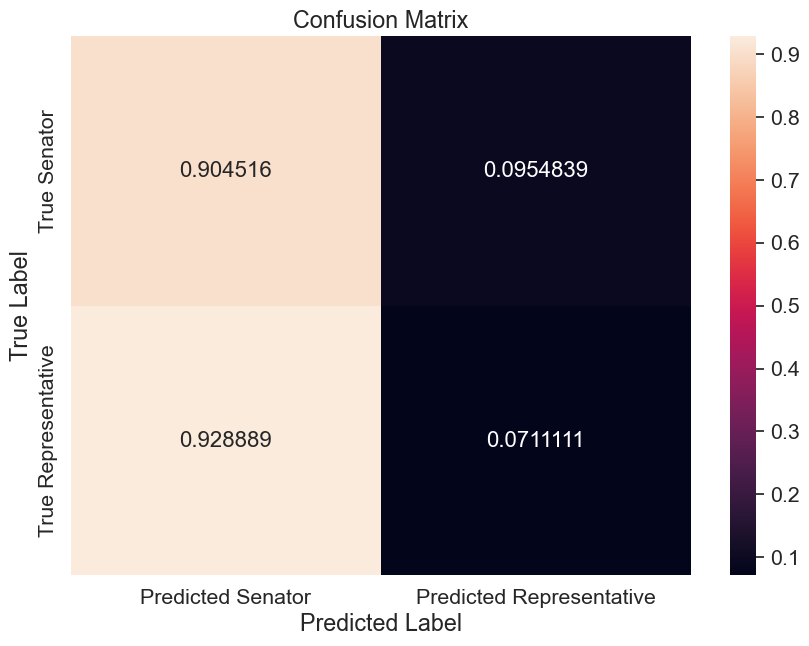

In [69]:
# Create a DataFrame for better visualization
position_engineeredfeaturesdfcf_matrix = confusion_matrix(y_val_position, y_val_pred_position, normalize="true")
position_engineeredfeaturesdf_cm = pd.DataFrame(position_engineeredfeaturesdfcf_matrix, 
                     index=["True Senator", "True Representative"], 
                     columns=["Predicted Senator", "Predicted Representative"])

# plot specifications
# ----------
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(position_engineeredfeaturesdf_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Model 3 - Predicting Party with TF-IDF

In [77]:
party_labels = congress_tweets['party']
X = tfidf_df
y = party_labels

In [78]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_temp, y_train_party, y_temp_party = train_test_split(
    X,  # Features (TF-IDF matrix)
    y,  # Target (party labels)
    test_size=0.4, random_state=42
)

# Further split into validation and test sets (50% of the remaining data for validation, 50% for test)
X_val, X_test, y_val_party, y_test_party = train_test_split(X_temp, y_temp_party, test_size=0.5, random_state=42)


In [79]:
# Initialize the RandomForest model
rf_party = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model for Democrat/Republican prediction using TF-IDF features
rf_party.fit(X_train, y_train_party)

# Predict on the validation set
y_val_pred_party = rf_party.predict(X_val)

# Evaluate the model
print("Democrat/Republican Model (TF-IDF Features) - Accuracy:", accuracy_score(y_val_party, y_val_pred_party))
print(classification_report(y_val_party, y_val_pred_party)) 

Democrat/Republican Model (TF-IDF Features) - Accuracy: 0.67
              precision    recall  f1-score   support

    Democrat       0.71      0.84      0.77       661
  Republican       0.52      0.35      0.41       339

    accuracy                           0.67      1000
   macro avg       0.62      0.59      0.59      1000
weighted avg       0.65      0.67      0.65      1000



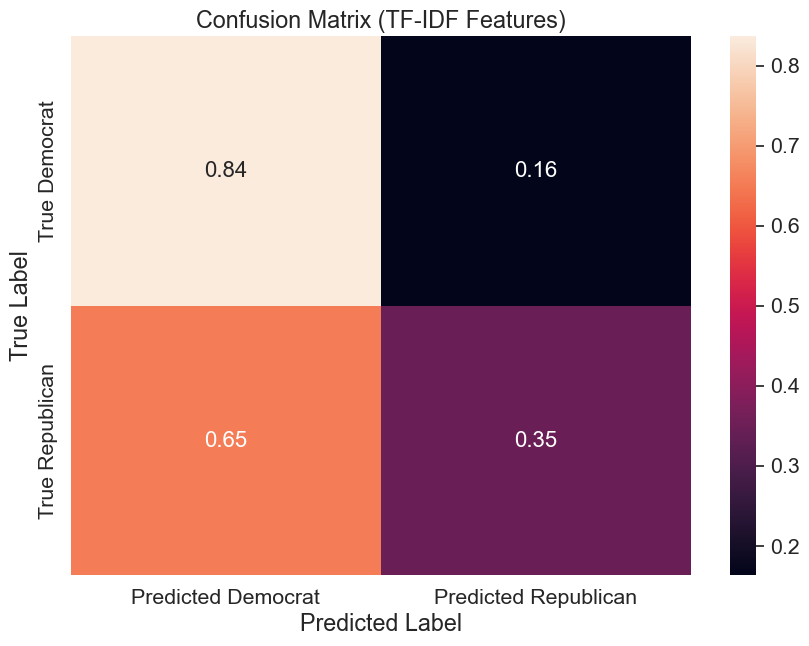

In [80]:
# Create a normalized confusion matrix for better visualization
party_tfidf_cf_matrix = confusion_matrix(y_val_party, y_val_pred_party, normalize="true")
party_tfidf_cm = pd.DataFrame(party_tfidf_cf_matrix, 
                     index=["True Democrat", "True Republican"], 
                     columns=["Predicted Democrat", "Predicted Republican"])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(party_tfidf_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='.2f')  # Format the matrix as floating-point values for percentage

plt.title('Confusion Matrix (TF-IDF Features)')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Model 4 - Predicting Position (Senate/House of Representatives) with TF-IDF

In [81]:
position_labels = congress_tweets['position']
X = tfidf_df
y = position_labels

In [82]:
# Split the data into training and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train_position, y_temp_position = train_test_split(
    X,  # Features (TF-IDF matrix)
    y,  # Target (position labels)
    test_size=0.4, random_state=42
)

# Further split into validation and test sets (50% of the remaining data for validation, 50% for test)
X_val, X_test, y_val_position, y_test_position = train_test_split(X_temp, y_temp_position, test_size=0.5, random_state=42)


In [83]:

# Initialize the RandomForest model
rf_position = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training set (X_train, y_train_position)
rf_position.fit(X_train, y_train_position)

# Predict on the validation set
y_val_pred_position = rf_position.predict(X_val)

# Evaluate the model
print("Position Model (TF-IDF Features) - Accuracy:", accuracy_score(y_val_position, y_val_pred_position))
print(classification_report(y_val_position, y_val_pred_position))


Position Model (TF-IDF Features) - Accuracy: 0.761
              precision    recall  f1-score   support

         Rep       0.80      0.93      0.86       775
         Sen       0.43      0.18      0.26       225

    accuracy                           0.76      1000
   macro avg       0.61      0.56      0.56      1000
weighted avg       0.71      0.76      0.72      1000



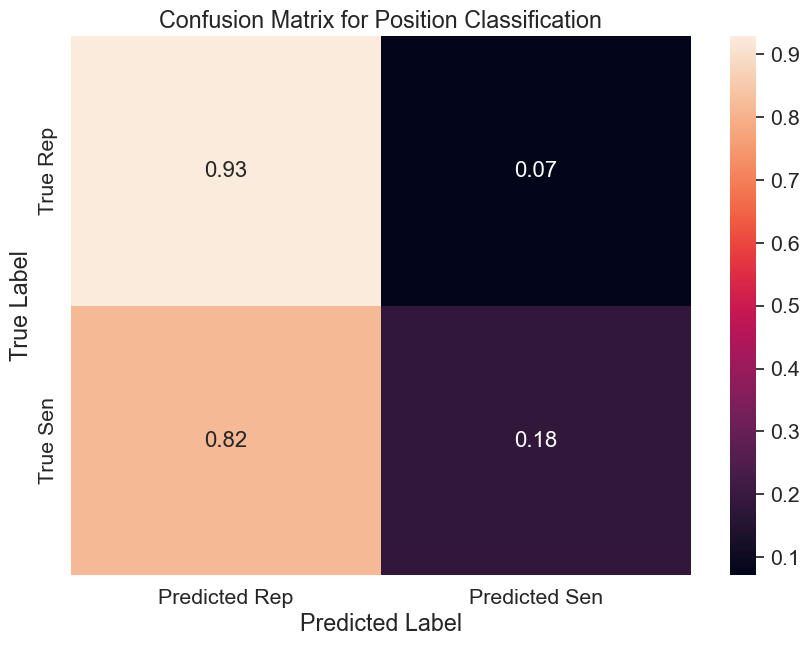

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix (normalized)
cf_matrix_position = confusion_matrix(y_val_position, y_val_pred_position, normalize="true")

# Create a DataFrame for better visualization
cf_matrix_df_position = pd.DataFrame(cf_matrix_position, 
                                    index=["True Rep", "True Sen"],  # Actual (True) labels
                                     columns=["Predicted Rep", "Predicted Sen"])  # Predicted labels

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # For label size
sns.heatmap(cf_matrix_df_position, 
            annot=True,
            annot_kws={"size": 16},
            fmt='.2f')  # For percentage format

plt.title('Confusion Matrix for Position Classification')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Model 5 - Predicting Party with Word Embeddings

In [106]:
# Features are the embeddings (all columns except 'party' and 'position')
X_party = embedding_df.drop(['party', 'position'], axis=1)

# Target is the party column
y_party = embedding_df['party']


In [107]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train_party, y_test_party = train_test_split(
    X_party,  # Features (embeddings)
    y_party,  # Target (party labels)
    test_size=0.2, random_state=42
)


In [108]:
# Initialize the RandomForest model
wordembeddings_rf_party = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model for party prediction
wordembeddings_rf_party.fit(X_train, y_train_party)

# Predict on the test set
y_pred_party = wordembeddings_rf_party.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("Party Prediction Accuracy:", accuracy_score(y_test_party, y_pred_party))
print(classification_report(y_test_party, y_pred_party))


Party Prediction Accuracy: 0.668
              precision    recall  f1-score   support

    Democrat       0.68      0.95      0.79       673
  Republican       0.46      0.08      0.14       327

    accuracy                           0.67      1000
   macro avg       0.57      0.52      0.47      1000
weighted avg       0.61      0.67      0.58      1000



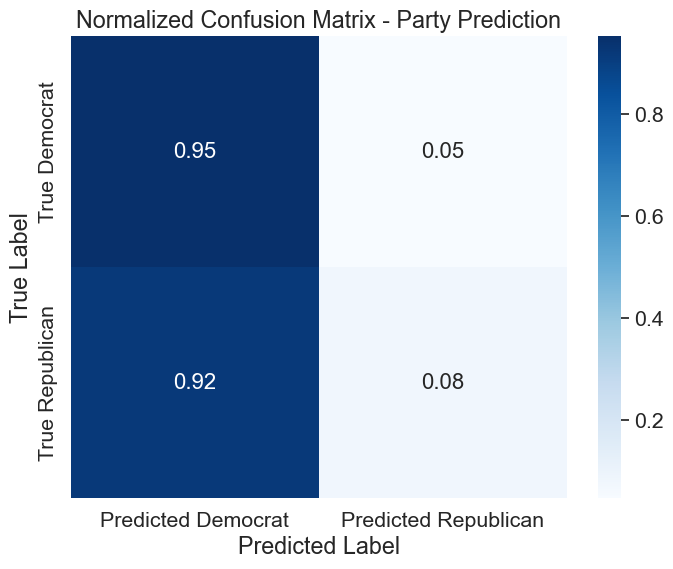

In [109]:
# Compute the normalized confusion matrix
wordembeddingscm_party = confusion_matrix(y_test_party, y_pred_party, normalize='true')

# Convert the confusion matrix to a DataFrame for better visualization
wordembeddingscm_party_df = pd.DataFrame(wordembeddingscm_party, 
                           index=["True Democrat", "True Republican"], 
                           columns=["Predicted Democrat", "Predicted Republican"])

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust label size
sns.heatmap(wordembeddingscm_party_df, annot=True, fmt='.2f', cmap='Blues', cbar=True, annot_kws={"size": 16})

plt.title('Normalized Confusion Matrix - Party Prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Model 6 - Predicting Position (Senate/House of Representatives) with Word Embeddings

In [110]:
# Now for Position
X_position = embedding_df.drop(['party', 'position'], axis=1)
y_position = embedding_df['position']

In [111]:
# For position 
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_position,  # Features (embeddings)
    y_position,  # Target (position labels)
    test_size=0.2, random_state=42
)


In [112]:

# Initialize the RandomForest model for position prediction
wordembeddings_rf_position = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model for position prediction
wordembeddings_rf_position.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_position = wordembeddings_rf_position.predict(X_test_pos)

# Evaluate the model
print("Position Prediction Accuracy:", accuracy_score(y_test_pos, y_pred_position))
print(classification_report(y_test_pos, y_pred_position))

Position Prediction Accuracy: 0.76
              precision    recall  f1-score   support

         Rep       0.76      1.00      0.86       763
         Sen       0.00      0.00      0.00       237

    accuracy                           0.76      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.58      0.76      0.66      1000



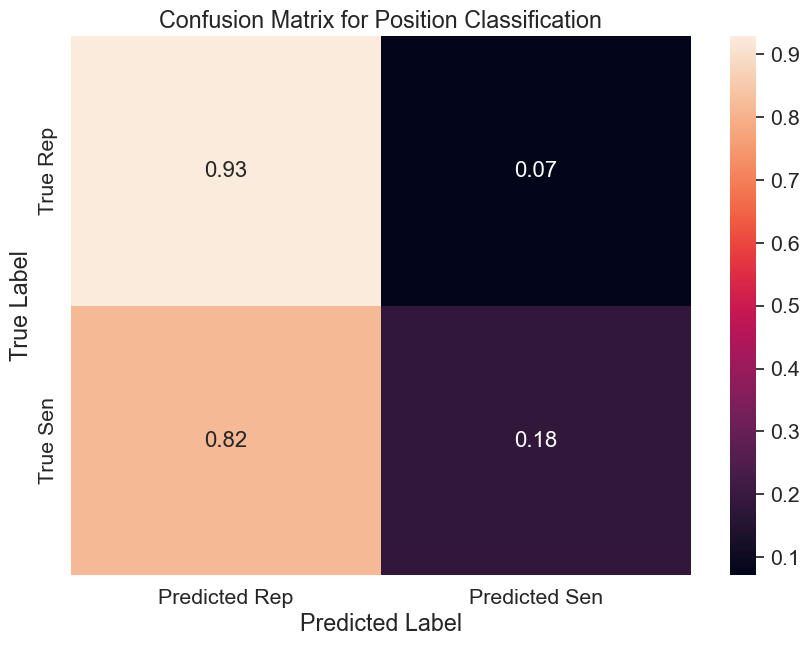

In [113]:
# Create confusion matrix (normalized)
wordembeddings_cf_matrix_position = confusion_matrix(y_val_position, y_val_pred_position, normalize="true")

# Create a DataFrame for better visualization
wordembeddings_cf_matrix_df_position = pd.DataFrame(wordembeddings_cf_matrix_position, 
                                    index=["True Rep", "True Sen"],  # Actual (True) labels
                                     columns=["Predicted Rep", "Predicted Sen"])  # Predicted labels

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # For label size
sns.heatmap(cf_matrix_df_position, 
            annot=True,
            annot_kws={"size": 16},
            fmt='.2f')  # For percentage format

plt.title('Confusion Matrix for Position Classification')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...